In [1]:
import tensorflow as tf
from tensorflow.keras import Input, Model, layers
import numpy as np 
import matplotlib.pyplot as plt
import json
import os 
from PIL import Image

In [32]:
AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API

TEST_FILENAMES = '../datasets/google_split_tfrec/test.tfrec' 
BATCH_SIZE = 1

SEED = tf.Variable(256)

In [3]:
def parse_tfrecord_fn(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "path": tf.io.FixedLenFeature([], tf.string),
        "device": tf.io.FixedLenFeature([], tf.string),
        "screen_h": tf.io.FixedLenFeature([], tf.int64),
        "screen_w": tf.io.FixedLenFeature([], tf.int64),
        "face_valid": tf.io.FixedLenFeature([], tf.int64),
        "face_x": tf.io.FixedLenFeature([], tf.int64),
        "face_y": tf.io.FixedLenFeature([], tf.int64),
        "face_w": tf.io.FixedLenFeature([], tf.int64),
        "face_h": tf.io.FixedLenFeature([], tf.int64),
        "leye_x": tf.io.FixedLenFeature([], tf.int64),
        "leye_y": tf.io.FixedLenFeature([], tf.int64),
        "leye_w": tf.io.FixedLenFeature([], tf.int64),
        "leye_h": tf.io.FixedLenFeature([], tf.int64),
        "reye_x": tf.io.FixedLenFeature([], tf.int64),
        "reye_y": tf.io.FixedLenFeature([], tf.int64),
        "reye_w": tf.io.FixedLenFeature([], tf.int64),
        "reye_h": tf.io.FixedLenFeature([], tf.int64),
        "dot_xcam": tf.io.FixedLenFeature([], tf.float32),
        "dot_y_cam": tf.io.FixedLenFeature([], tf.float32),
        "dot_x_pix": tf.io.FixedLenFeature([], tf.float32),
        "dot_y_pix": tf.io.FixedLenFeature([], tf.float32),
        "reye_x1": tf.io.FixedLenFeature([], tf.int64),
        "reye_y1": tf.io.FixedLenFeature([], tf.int64),
        "reye_x2": tf.io.FixedLenFeature([], tf.int64),
        "reye_y2": tf.io.FixedLenFeature([], tf.int64),
        "leye_x1": tf.io.FixedLenFeature([], tf.int64),
        "leye_y1": tf.io.FixedLenFeature([], tf.int64),
        "leye_x2": tf.io.FixedLenFeature([], tf.int64),
        "leye_y2": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_jpeg(example["image"], channels=3)
    return example


def augmentation(image, training = True):
    if training:
        aug = tf.keras.Sequential([
                layers.Resizing(128+10, 128+10),
                layers.RandomCrop(128, 128, 256),
                layers.Rescaling(1./255),
                layers.Normalization(mean = (0.3741, 0.4076, 0.5425), variance = (0.0004, 0.0004, 0.0004))
                ])
        
    else:
        aug = tf.keras.Sequential([
                layers.Resizing(128, 128),
                layers.Rescaling(1./255),
                layers.Normalization(mean = (0.3741, 0.4076, 0.5425), variance = (0.0004, 0.0004, 0.0004))
                ])
    
    image = aug(image)
    
    return image

def prepare_eval_sample(features):
    img_feat = features['image']

    h = tf.shape(img_feat)[0]
    w = tf.shape(img_feat)[1]

    w = tf.cast(w, tf.int64)
    h = tf.cast(h, tf.int64)

    screen_w, screen_h = features['screen_w'], features['screen_h']

    kps = [features['leye_x1']/w, features['leye_y1']/h, features['leye_x2']/w, features['leye_y2']/h,
           features['reye_x1']/w, features['reye_y1']/h, features['reye_x2']/w, features['reye_y2']/h]
    # kps has type float64

    lx, ly, lw, lh = int(features['leye_x']), int(features['leye_y']), int(features['leye_w']), int(features['leye_h'])
    rx, ry, rw, rh = int(features['reye_x']), int(features['reye_y']), int(features['reye_w']), int(features['reye_h'])

    lx = tf.clip_by_value(lx, 0, int(w)-lw)
    ly = tf.clip_by_value(ly, 0, int(h)-lh)

    rx = tf.clip_by_value(rx, 0, int(w)-rw)
    ry = tf.clip_by_value(ry, 0, int(h)-rh)

    l_eye = tf.image.crop_to_bounding_box(img_feat, ly, lx, lh, lw)
    r_eye = tf.image.crop_to_bounding_box(img_feat, ry, rx, rh, rw)

    l_eye = tf.image.flip_left_right(l_eye)

    l_eye = augmentation(l_eye, False)
    r_eye = augmentation(r_eye, False)

    y = [features['dot_xcam'], features['dot_y_cam']]
    # y has type float32
    
    path = features['path']

    return (l_eye, r_eye, kps), y, path

    # return (l_eye, r_eye, kps), y



def get_eval_dataset(filenames, batch_size):
    option_no_order = tf.data.Options()
    option_no_order.deterministic = False  # disable order, increase speed
    
    dataset = (
        tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
        .with_options(option_no_order)
        .map(parse_tfrecord_fn, num_parallel_calls=AUTO)
        .map(prepare_eval_sample, num_parallel_calls=AUTO)
        .batch(batch_size)
    )
    
    dataset_len = sum(1 for _ in tf.data.TFRecordDataset(filenames))
    print(f"No. of samples: {dataset_len}")
    
    return dataset

In [33]:
test_dataset = get_eval_dataset(TEST_FILENAMES, BATCH_SIZE)

No. of samples: 83849


# Model

In [18]:
new_model = tf.keras.models.load_model('../checkpoints/new_mod/gs/rlrop100/epoch-94-vl-2.445.ckpt') 

In [19]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 8)]          0           []                               
                                                                                              

In [ ]:
loss, rmse = new_model.evaluate(x=test_dataset,
                                batch_size=BATCH_SIZE,
                                verbose=1
                                )

In [7]:
def euc(a, b):
    return np.sqrt(np.sum(np.square(a - b), axis=1))

In [8]:
def root_mean_squared_error(y_pred, y_true):   #always pred-true
    return np.sqrt(np.mean(np.square(y_pred - y_true))) 

In [26]:
def tensor2str(path):
    path_np = np.array(path)
    path_str = np.array_str(path_np)
    result_1 = path_str.split('images/', 1)[1]
    image_id = result_1.split('.jpg', 1)[0]
    return image_id

# Get preds

In [48]:
preds, gt = [], []
count = 0
for x_test,y_test, path in test_dataset:
    # print(path)
    image_id = tensor2str(path)
    if image_id.startswith('02459'):
        print(image_id)
        count= count+1
        pred = new_model.predict(x_test)
        preds.extend(pred)
        gt.extend(y_test)
    
print(count)

02459__00207
1/1 [==============================] - 0s 27ms/step
02459__00208
1/1 [==============================] - 0s 25ms/step
02459__00209
1/1 [==============================] - 0s 24ms/step
02459__00210
1/1 [==============================] - 0s 25ms/step
02459__00211
1/1 [==============================] - 0s 24ms/step
02459__00212
1/1 [==============================] - 0s 24ms/step
02459__00213
1/1 [==============================] - 0s 24ms/step
02459__00214
1/1 [==============================] - 0s 25ms/step
02459__00215
1/1 [==============================] - 0s 23ms/step
02459__00216
1/1 [==============================] - 0s 24ms/step
02459__00217
1/1 [==============================] - 0s 24ms/step
02459__00218
1/1 [==============================] - 0s 24ms/step
02459__00219
1/1 [==============================] - 0s 23ms/step
02459__00220
1/1 [==============================] - 0s 24ms/step
02459__00221
1/1 [==============================] - 0s 29ms/step
02459__00222
1/1 [=======

# Results

In [49]:
preds = np.array(preds)
pts = np.unique(gt, axis=0)
gt = np.array(gt)
dist = euc(preds, gt)
print("Mean Euclidean Distance: ", dist.mean())
print("Root MSE", root_mean_squared_error(preds, gt))

Mean Euclidean Distance:  1.1057646
Root MSE 0.85938776


# Plots

In [50]:
import colorsys
import random
def get_colors(num_colors):
    colors=[]
    for i in np.arange(0., 360., 360. / num_colors):
        hue = i/360.
        lightness = (50 + np.random.rand() * 10)/100.
        saturation = (90 + np.random.rand() * 10)/100.
        colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
    return colors

c = get_colors(len(pts))
random.shuffle(c)

(-13.0, 0.2)

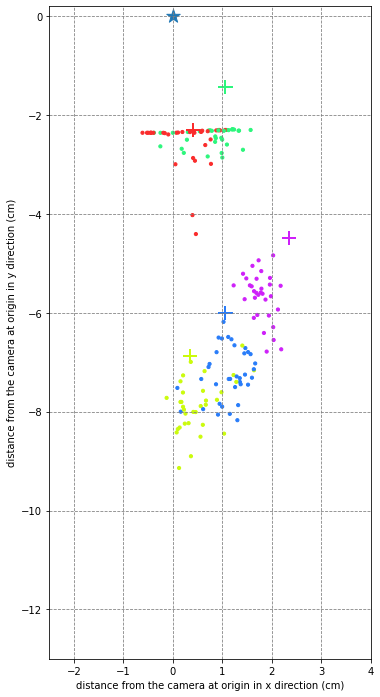

In [51]:
cols = np.zeros((len(gt),3))
for i in range(len(pts)):
    cols[np.where(np.all(gt==pts[i],axis=1))] = c[i]
    
plt.figure(figsize=(12,12))
plt.grid(color='gray', linestyle='dashed')
plt.scatter(0, 0, marker='*', s=200)
plt.scatter(preds[:,0], preds[:,1], c=cols, s=10)
plt.scatter(gt[:,0], gt[:,1], c=cols, marker='+', s=200)
plt.xlabel('distance from the camera at origin in x direction (cm)')
plt.ylabel('distance from the camera at origin in y direction (cm)')
plt.axis('scaled')
plt.xlim(-2.5, 4)
plt.ylim(-13, 0.2)